In [216]:
import torchaudio
torchaudio.set_audio_backend("soundfile")
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torch
print(torch.__version__)
from torch import nn
from tqdm import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import os
import warnings
import gc
from copy import deepcopy
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import librosa
import numpy as np
import noisereduce as nr
warnings.filterwarnings("ignore")

1.8.0+cu111


# help function

In [217]:
def trim_and_padding(y,time_length = int(80000*0.9)):
    if 0 < len(y): 
        y, _ = librosa.effects.trim(y, top_db=20, frame_length=512, hop_length=64)
    if len(y) > time_length:
            y = y[0:0+time_length]
    else: # pad blank
        padding = time_length - len(y)
        offset = padding // 2
        y = np.pad(y, (offset, time_length - len(y) - offset))
    return y

def Shifting_Time(data, sampling_rate=16000, shift_max=1, shift_direction='both'):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

def Changing_Pitch(data):
    return librosa.effects.pitch_shift(data,sr=16000,n_steps=np.random.choice([-3,-2,-1,1,2,3]))

def Changing_Speed(data):
    return librosa.effects.time_stretch(data, rate=np.random.choice([1.25,0.85]))

aug_method = {}
aug_method[0] = Shifting_Time
aug_method[1] = Changing_Pitch
aug_method[2] = Changing_Speed

# PATH

In [218]:
X_train_dir = 'train/train/'
X_test_dir = 'public_test/public_test/'
Y_train_path = 'train/meta_train.csv'

# wav 2 features flow

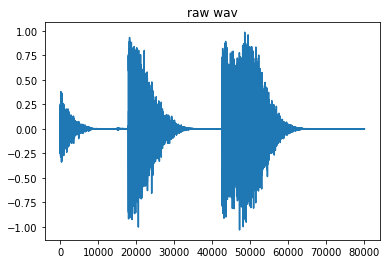

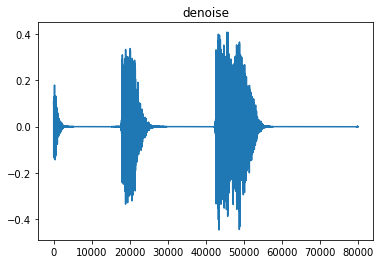

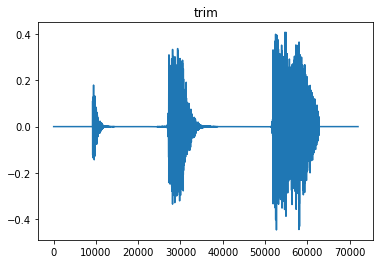

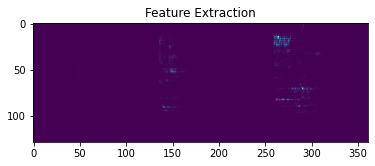

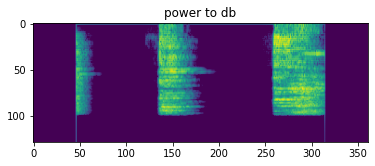

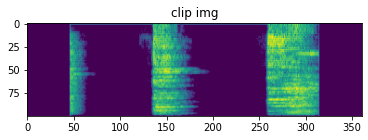

In [219]:
# raw wav
samples, sample_rate = librosa.load(X_train_dir+os.listdir(X_train_dir)[1],sr=16000)
plt.title('raw wav')
plt.plot(samples)
plt.show()

# denoise
noisy_part = samples[:]
reduced_noise = nr.reduce_noise(audio_clip=samples,noise_clip=noisy_part, verbose=False)
plt.title('denoise')
plt.plot(reduced_noise)
plt.show()

#trim these portions of the waveform
trimmed = trim_and_padding(reduced_noise)
plt.title('trim')
plt.plot(trimmed)
plt.show()

# Feature Extraction
melspectrogram = librosa.feature.melspectrogram(y=trimmed, sr=16000, S=None, n_fft=400, hop_length=400//2)
plt.title('Feature Extraction')
plt.imshow(melspectrogram)
plt.show()

# power to db
melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
plt.title('power to db')
plt.imshow(melspectrogram)
plt.show()

# clip img
melspectrogram = melspectrogram[:100,:]
plt.title('clip img')
plt.imshow(melspectrogram)
plt.show()

# data augmentation method

0


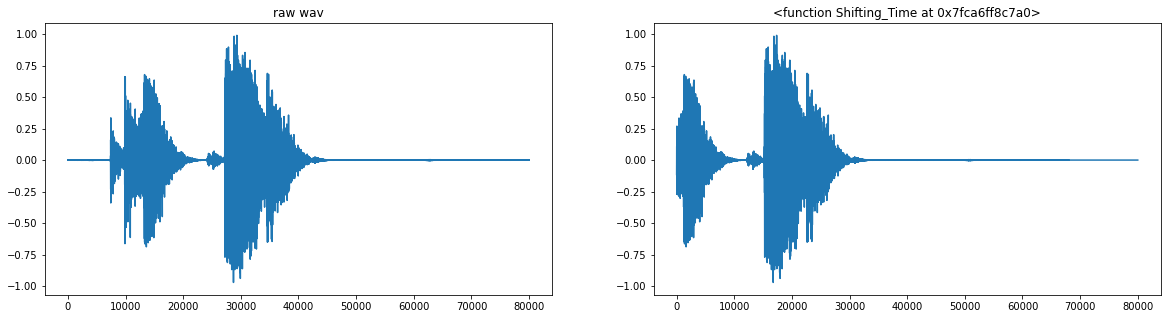

1


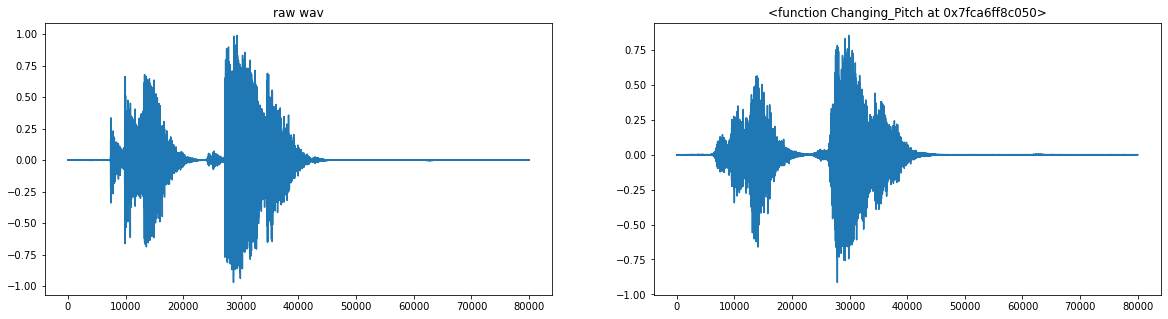

2


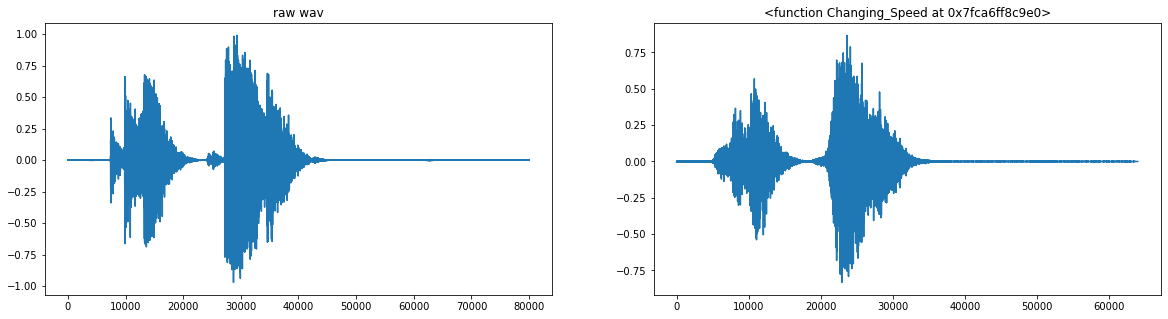

In [220]:
for k in aug_method.keys():
    print(k)
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    samples, sample_rate = librosa.load(X_train_dir+os.listdir(X_train_dir)[0],sr=16000)
    plt.title('raw wav')
    plt.plot(samples)
    plt.subplot(1,2,2)
    samples = aug_method[k](samples)
    plt.title(str(aug_method[k]))
    plt.plot(samples)
    plt.show()

# preprocessing 

In [221]:
def sample2melspectrogram(samples,sample_rate):
    # 1.denoise
    reduced_noise = nr.reduce_noise(audio_clip=samples,noise_clip=samples[0:-1], verbose=False)
    # 2.trim
    trimmed = trim_and_padding(reduced_noise)
    # 3.Feature Extraction
    melspectrogram = librosa.feature.melspectrogram(y=trimmed, sr=16000, S=None, n_fft=400, hop_length=400//2)
    # 4.power to db
    melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
    # 5.clip img
    melspectrogram = melspectrogram[:100,:]
    return melspectrogram

def preprocessing_X(wav_dir,mode='train'):
    files = os.listdir(wav_dir)
    files.sort() #正確排序很重要
    X = torch.FloatTensor([])
    n = 12
    if mode == 'test':
        n = 100
    for f in tqdm(files[::n]):
        samples, sample_rate = librosa.load(wav_dir+f,sr=16000)
        mel_spectrogram = sample2melspectrogram(samples,sample_rate)
        shape = mel_spectrogram.shape
        mel_spectrogram = np.reshape(mel_spectrogram, (-1, shape[0], shape[1]))
        mel_spectrogram = torch.from_numpy(mel_spectrogram)
        X = torch.cat([X,torch.unsqueeze(mel_spectrogram,0)],dim=0)
    print('X shape:',X.shape)
    return X

def preprocessing_Y(file_path):
    Y = pd.read_csv(file_path)
    Y = Y.iloc[::12,:]
    enc = OneHotEncoder().fit(Y[['Label']])
    Y_one_hot = enc.transform(Y[['Label']]).toarray()
    Y_one_hot = torch.FloatTensor(Y_one_hot)
    print('Y_ont_hot shape',Y_one_hot.shape)
    print('Y_df shape',Y.shape)
    return Y_one_hot,Y

def preprocessing_X_with_Augmentation(wav_dir,aug_method_idx=0):
    files = os.listdir(wav_dir)
    files.sort() #正確排序很重要
    X = torch.FloatTensor([])
    for f in tqdm(files[::12]):
        samples, sample_rate = librosa.load(wav_dir+f,sr=16000)
        aug_method[aug_method_idx](samples)
        mel_spectrogram = sample2melspectrogram(samples,sample_rate)
        shape = mel_spectrogram.shape
        mel_spectrogram = np.reshape(mel_spectrogram, (-1, shape[0], shape[1]))
        mel_spectrogram = torch.from_numpy(mel_spectrogram)
        X = torch.cat([X,torch.unsqueeze(mel_spectrogram,0)],dim=0)
    print('X shape:',X.shape)
    return X

# Load X

In [222]:
X_train = preprocessing_X(X_train_dir)
X_train_aug0 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=0)
X_train_aug1 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=1)
X_train_aug2 = preprocessing_X_with_Augmentation(X_train_dir,aug_method_idx=2)
X_train = torch.cat([X_train,X_train_aug0,X_train_aug1,X_train_aug2],dim=0)
print(X_train.shape)
torch.save(X_train,'X_train.pt')
X_test = preprocessing_X(X_test_dir,mode='test')
print(X_test.shape)
torch.save(X_test,'X_test.pt')

  1%|          | 1/100 [00:00<00:16,  6.16it/s]

X shape: torch.Size([100, 1, 100, 361])


  0%|          | 0/100 [00:00<?, ?it/s]

X shape: torch.Size([100, 1, 100, 361])


  0%|          | 0/100 [00:00<?, ?it/s]

X shape: torch.Size([100, 1, 100, 361])


100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


X shape: torch.Size([100, 1, 100, 361])
torch.Size([400, 1, 100, 361])


100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


X shape: torch.Size([100, 1, 100, 361])
torch.Size([100, 1, 100, 361])


In [228]:
X_train.shape,X_test.shape

(torch.Size([400, 1, 100, 361]), torch.Size([100, 1, 100, 361]))

In [229]:
if 'X_train.pt' in os.listdir():
    X_train = torch.load('X_train.pt')
    print('load')
print(X_train.shape)

load
torch.Size([400, 1, 100, 361])


In [230]:
if 'X_test.pt' in os.listdir():
    X_test = torch.load('X_test.pt')
    print('load')
print(X_test.shape)

load
torch.Size([100, 1, 100, 361])


# load Y

In [231]:
Y_train,Y_train_df = preprocessing_Y(Y_train_path)
Y_train = np.vstack((Y_train,
                     Y_train,
                     Y_train,
                     Y_train))
print(Y_train.shape)
map_dict = {}
for l in Y_train_df.Label.unique():
    map_dict[l] = Y_train_df[Y_train_df.Label==l].sample(1)['Remark'].values[0]
map_dict

Y_ont_hot shape torch.Size([100, 6])
Y_df shape (100, 3)
(400, 6)


{0: 'Barking',
 1: 'Howling',
 2: 'Crying',
 3: 'COSmoke',
 4: 'GlassBreaking',
 5: 'Electrics'}

# look some sample

In [232]:
def plot_feature_by_class_name(class_name,X,label_df):
    try:
        plt.figure(figsize=(20,5))
        for i,filename in enumerate([i+'.wav' for i in label_df[label_df.Remark==class_name].sample(3)['Filename'].values]):
            feature = X[int(filename.split('_')[1].split('.')[0])]
            plt.subplot(1,3,i+1)
            plt.imshow(feature[0,:,:])
            title = 'class:{} filename:{}'.format(class_name,filename)
            plt.title(title)
        plt.tight_layout()
        plt.show()
    except:
        print(class_name)

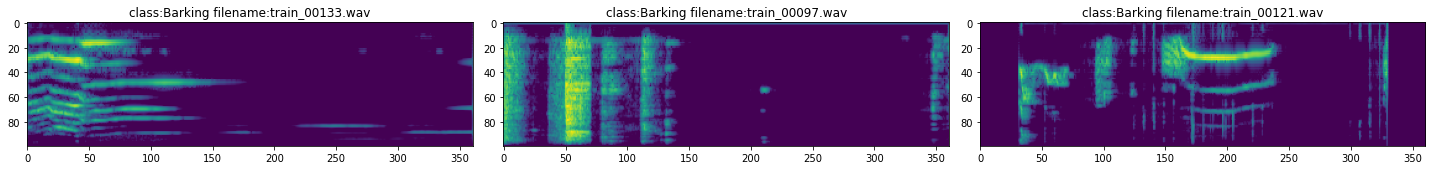

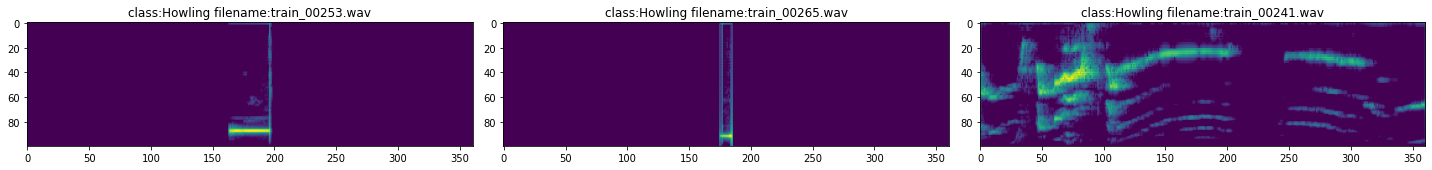

Crying
COSmoke
GlassBreaking
Vacuum
Blender
Electrics
Cat
Dishes


<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

<Figure size 1440x360 with 0 Axes>

In [233]:
for class_name in Y_train_df.Remark.unique():
    plot_feature_by_class_name(class_name,X_train,Y_train_df)

# train valid split

In [234]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42,stratify=Y_train)
print(pd.DataFrame(y_train.argmax(axis=1)).value_counts())
print(pd.DataFrame(y_valid.argmax(axis=1)).value_counts())

1    58
4    55
0    54
3    54
5    51
2    48
dtype: int64
0    14
1    14
3    14
4    13
5    13
2    12
dtype: int64


#  create pytorch dataloader and save

In [235]:
from torch.utils.data import TensorDataset,DataLoader
trainset = TensorDataset(torch.FloatTensor(X_train.to(torch.float32)),torch.FloatTensor(y_train))
vaildset = TensorDataset(torch.FloatTensor(X_valid.to(torch.float32)),torch.FloatTensor(y_valid))
train_iter = DataLoader(trainset,batch_size=5,num_workers=4)
vaild_iter = DataLoader(vaildset,batch_size=5,num_workers=4)
torch.save(train_iter, 'train_iter.pt')
torch.save(vaild_iter, 'vaild_iter.pt')
train_iter = torch.load('train_iter.pt')
vaild_iter = torch.load('vaild_iter.pt')

In [236]:
for bx,by in train_iter:
    print(bx.shape) # batch,channel,freq,time
    print(by.shape) # batch,n_class
    print(bx.device)
    print(by.device)
    break

torch.Size([5, 1, 100, 361])
torch.Size([5, 6])
cpu
cpu


# define model

In [248]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1,6,5)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*22*87,120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,6)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        x = x.view(-1,16*22*87)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x
    
    def look_feature_map(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        return x

#model = LeNet()
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet18', pretrained=False)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Sequential(nn.Linear(512,256),nn.ReLU(),
                         nn.Linear(256,6),nn.Softmax(dim=1))
model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# model forward test

In [249]:
y_hat = model(bx)
print(bx.shape,y_hat.shape)
y_hat

torch.Size([5, 1, 100, 361]) torch.Size([5, 6])


tensor([[0.2079, 0.1576, 0.1711, 0.1393, 0.1692, 0.1549],
        [0.2049, 0.1549, 0.1724, 0.1460, 0.1633, 0.1586],
        [0.2147, 0.1547, 0.1740, 0.1395, 0.1584, 0.1587],
        [0.2176, 0.1500, 0.1714, 0.1361, 0.1642, 0.1607],
        [0.2048, 0.1524, 0.1734, 0.1441, 0.1621, 0.1631]],
       grad_fn=<SoftmaxBackward>)

# def train loop

In [250]:
def train_step(model,train_iter,loss_fn,optimizer,device):
        model.train()
        total_loss = 0
        total_auc = 0
        for t,(x,y) in enumerate(train_iter):
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            total_auc += calculate_auc_score(model,x,y)
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        return total_loss/(t+1) ,total_auc/(t+1)

def valid_step(model,vaild_iter,loss_fn,optimizer,device):
    model.eval()
    total_loss = 0
    total_auc = 0
    for t,(x,y) in enumerate(vaild_iter):
        x,y = x.to(device),y.to(device)
        y_hat = model(x)
        total_auc += calculate_auc_score(model,x,y)
        loss = loss_fn(y_hat,y)
        total_loss += loss.item()
    return total_loss/(t+1) ,total_auc/(t+1)

def softmax2onehot(probs):
  probs = torch.FloatTensor(probs)
  max_idx = torch.argmax(probs, 1, keepdim=True)
  one_hot = torch.FloatTensor(probs.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot.detach().cpu().numpy().astype(int)

# calculate roc_auc_score
def calculate_auc_score(model,x,y):
    y_hat = model(x).detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    return 0 #roc_auc_score(y_hat,y)


# train_loop
def train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=300,log_interval=10,device=None):
        history = {
            'train_loss':[],
            'valid_loss':[],
            'train_auc':[],
            'valid_auc':[],
            }
        current_loss = np.inf
        best_model = None
        for i in tqdm(range(max_epochs)):
            # step
            train_loss,train_auc = train_step(model,train_iter,loss_fn,optimizer,device)
            valid_loss,valid_auc = valid_step(model,vaild_iter,loss_fn,optimizer,device)
            # record history
            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)
            history['train_auc'].append(train_auc)
            history['valid_auc'].append(valid_auc)
            # print info
            if i % log_interval == 0:
                print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f} train_auc:{:.4f} valid_auc:{:.4f}".format(
                    i,history['train_loss'][-1],history['valid_loss'][-1],history['train_auc'][-1],history['valid_auc'][-1])
                    )
            # record the best model
            if history['valid_loss'][-1] <= current_loss:
                best_model = deepcopy(model.eval())
                current_loss = history['valid_loss'][-1]
        # copy best model
        model = deepcopy(best_model.eval())
        
        # plot
        plt.plot(history['train_loss'],label='train_loss')
        plt.plot(history['valid_loss'],label='valid_loss')
        plt.legend()
        plt.savefig('loss.jpg')
        plt.show()
        
        
        plt.plot(history['train_auc'],label='train_auc')
        plt.plot(history['valid_auc'],label='valid_auc')
        plt.legend()
        plt.savefig('auc.jpg')
        plt.show()
        
        
        return model

  0%|          | 0/30 [00:00<?, ?it/s]

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

  3%|▎         | 1/30 [00:08<04:05,  8.46s/it]

epoch:0 train_loss:0.7506 valid_loss:0.7668 train_auc:0.0000 valid_auc:0.0000


 37%|███▋      | 11/30 [01:32<02:36,  8.26s/it]

epoch:10 train_loss:0.6761 valid_loss:0.6779 train_auc:0.0000 valid_auc:0.0000


 70%|███████   | 21/30 [02:56<01:16,  8.45s/it]

epoch:20 train_loss:0.6325 valid_loss:0.6395 train_auc:0.0000 valid_auc:0.0000


100%|██████████| 30/30 [04:11<00:00,  8.37s/it]


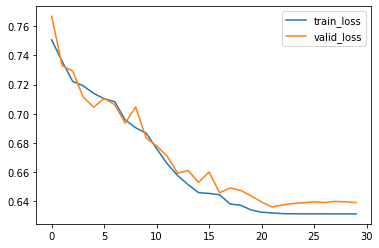

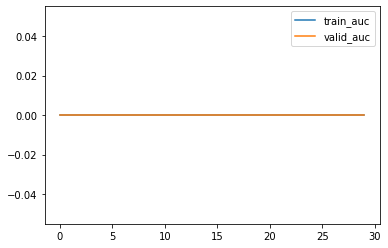

train done


In [251]:
device = 'cuda:0'
model = model.to(device)
print(model)
model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])
optimizer = Adam(model.parameters(),lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
model = train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=30,log_interval=10,device=device)
torch.save(model,'model.pt')
print('train done')

# model infernce test

In [252]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model,data_iter,map_dict=map_dict):
    y_true = np.array([])
    y_pred = np.array([])
    for bx,by in tqdm(data_iter):
        bx = bx.to(device)
        by = by.to(device)
        y_hat = model(bx)
        try:
            if len(y_true) == 0:
                y_true = by.argmax(axis=1).detach().cpu().numpy()
                y_pred = y_hat.argmax(axis=1).detach().cpu().numpy()
            else:
                y_true = np.hstack((y_true,by.argmax(axis=1).detach().cpu().numpy()))
                y_pred = np.hstack((y_pred,y_hat.argmax(axis=1).detach().cpu().numpy()))
        except:
            pass
    cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
    cm.columns = list(map_dict.values())
    return cm

In [253]:
cm = plot_confusion_matrix(model,train_iter)
cm.style.background_gradient()

100%|██████████| 64/64 [00:03<00:00, 19.65it/s]


,Barking,Howling,Crying,COSmoke,GlassBreaking,Electrics
0,54,0,0,0,0,0
1,0,55,0,0,0,0
2,0,0,48,0,0,0
3,0,0,0,47,0,0
4,0,0,0,0,55,0
5,0,3,0,7,0,51


In [254]:
cm = plot_confusion_matrix(model,vaild_iter)
cm.style.background_gradient()

100%|██████████| 16/16 [00:02<00:00,  7.02it/s]


,Barking,Howling,Crying,COSmoke,GlassBreaking,Electrics
0,14,0,0,0,0,0
1,0,13,0,0,0,0
2,0,0,12,0,0,0
3,0,0,0,13,0,0
4,0,0,0,0,13,0
5,0,1,0,1,0,13


In [255]:
model = model.to('cpu')
torch.save(model,'model.pt')
print('model save done')

model save done


# submit

In [263]:
print(X_test.shape[0])

100


In [274]:
# load model
sample_submit = pd.read_csv('sample_submission.csv')
model = torch.load('model.pt').cuda()
batch = 10
for i in tqdm(range(0,X_test.shape[0],batch)):
    sample_submit.iloc[i:i+batch,1:] = model(X_test[:10].to(torch.float32).cuda()).detach().cpu().numpy()
sample_submit

100%|██████████| 10/10 [00:00<00:00, 21.06it/s]


,Filename,Barking,Howling,Crying,COSmoke,GlassBreaking,Other
0,public_00001,0.034533,7.437979e-11,6.115186e-12,8.107341e-10,9.652719e-01,1.949046e-04
1,public_00002,0.933731,6.626846e-02,5.104336e-09,2.085944e-13,6.794342e-08,4.378709e-07
2,public_00003,0.000001,9.999828e-01,1.599037e-05,1.102549e-14,5.449200e-19,6.674977e-10
3,public_00004,0.625751,3.742490e-01,1.015014e-07,1.758709e-14,2.629136e-10,1.353795e-09
4,public_00005,0.972596,4.068206e-10,5.188530e-13,2.437516e-14,2.740433e-02,2.931221e-09
...,...,...,...,...,...,...,...
29995,private_19996,0.166600,1.666000e-01,1.666000e-01,1.666000e-01,1.666000e-01,1.670000e-01
29996,private_19997,0.166600,1.666000e-01,1.666000e-01,1.666000e-01,1.666000e-01,1.670000e-01
29997,private_19998,0.166600,1.666000e-01,1.666000e-01,1.666000e-01,1.666000e-01,1.670000e-01
29998,private_19999,0.166600,1.666000e-01,1.666000e-01,1.666000e-01,1.666000e-01,1.670000e-01


In [276]:
# save
sample_submit.to_csv('submit_2021_0601_0518_just_test.csv',index=False)
print('done')

done
